In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import os

In [2]:
current_working_directory = os.getcwd()
lab_directory = os.path.dirname(current_working_directory)
paper_dir = os.path.join(lab_directory, "paper")
folder_figures = os.path.join(paper_dir, "plots")
folder_tables = os.path.join(paper_dir, "tabelas")
data_folder = os.path.join(lab_directory, "data")
models_folder = os.path.join(lab_directory, "models")
final_models_folder = os.path.join(models_folder, "final_models")
final_models_stats_folder = os.path.join(
    models_folder, "final_models_stats_mods"
)

columns_Y = [
    "UpwardUsedSecondaryReserveEnergy",
    "DownwardUsedSecondaryReserveEnergy",
]

training_dataset_path = os.path.join(
    data_folder, "processed", "dados_2014-2022_new.csv"
)
training_dataset = pd.read_csv(training_dataset_path, index_col=0)
training_dataset["datetime"] = pd.to_datetime(training_dataset["datetime"])
training_dataset["Year"] = pd.to_datetime(
    training_dataset["year"], format="%Y"
)

years_to_use = [2019, 2020, 2021, 2022]
validation_dataset = training_dataset[
    training_dataset["year"].isin(years_to_use)
].reset_index(drop=True)
dataset = training_dataset.set_index("datetime")

In [3]:
stats_validation_target = "GPD norm2"
final_results_stats_csv_up = os.path.join(
    final_models_stats_folder,
    "UpwardUsedSecondaryReserveEnergy",
    "updata",
    "results.csv",
)
final_results_stats_csv_down = os.path.join(
    final_models_stats_folder,
    "DownwardUsedSecondaryReserveEnergy",
    "downdata",
    "results.csv",
)

final_folder_up_stats = os.path.join(
    os.path.dirname(final_results_stats_csv_up), stats_validation_target
)
final_folder_down_stats = os.path.join(
    os.path.dirname(final_results_stats_csv_down), stats_validation_target
)

lab_results_stats_up = pd.read_csv(final_results_stats_csv_up)
lab_results_stats_down = pd.read_csv(final_results_stats_csv_down)

In [4]:
validation_target = "GPD Positivo"
final_results_csv_up = os.path.join(
    final_models_folder,
    "UpwardUsedSecondaryReserveEnergy",
    "updata_new",
    "results.csv",
)
final_results_csv_down = os.path.join(
    final_models_folder,
    "DownwardUsedSecondaryReserveEnergy",
    "downdata_new",
    "results.csv",
)

final_folder_up = os.path.join(
    os.path.dirname(final_results_csv_up), validation_target
)
final_folder_down = os.path.join(
    os.path.dirname(final_results_csv_down), validation_target
)

lab_results_up = pd.read_csv(final_results_csv_up)
lab_results_down = pd.read_csv(final_results_csv_down)

In [5]:
def get_winner_results(folder_models, validation_dataset):
    wining_npz_path = os.path.join(folder_models, "best_model.npz")
    wining_json_path = os.path.join(folder_models, "best_model.json")

    with open(wining_json_path) as src:
        wining_json = json.load(src)
    winning_npz = np.load(wining_npz_path)

    precition_col_name = f"prediction_{wining_json["epoch"]}"

    prediction = winning_npz[precition_col_name].ravel()
    test = winning_npz["test"].ravel()
    benchmark = winning_npz["benchmark"].ravel()

    data = pd.DataFrame(
        {
            "prediction": prediction,
            "test": test,
            "benchmark": benchmark,
        }
    )
    data["datetime"] = pd.to_datetime(
        validation_dataset["datetime"], errors="coerce"
    )
    data["hour"] = validation_dataset["hour"]
    data["day"] = validation_dataset["day"]
    data["month"] = validation_dataset["month"]
    data["year"] = validation_dataset["year"]
    data["day_of_year"] = validation_dataset["day_of_year"]
    data["day_of_week"] = validation_dataset["day_of_week"]

    return data

In [6]:
updata_stats = get_winner_results(final_folder_up_stats, validation_dataset)
downdata_stats = get_winner_results(
    final_folder_down_stats, validation_dataset
)
updata = get_winner_results(final_folder_up, validation_dataset)
downdata = get_winner_results(final_folder_down, validation_dataset)

In [7]:
validation_dataset["UpwardPrediction"] = updata["prediction"]
validation_dataset["DownwardPrediction"] = downdata["prediction"]
validation_dataset["UpwardPrediction_stats"] = updata_stats["prediction"]
validation_dataset["DownwardPrediction_stats"] = downdata_stats["prediction"]

# Meter os resultados de stats negativos a 0
validation_dataset.loc[validation_dataset["UpwardPrediction_stats"]<0,"UpwardPrediction_stats"]=0
validation_dataset.loc[validation_dataset["DownwardPrediction_stats"]<0,"DownwardPrediction_stats"]=0

In [8]:
def get_best_rows_on_lab(
    lab_results, validation_target, group_by, nn=False, max_archs=None
):
    res = lab_results.loc[
        lab_results.groupby(group_by)[validation_target].idxmax()
    ]
    res = res[
        [
            group_by,
            "RMSE",
            "SAE",
            "AllocF",
            "AllocD",
            "GPD",
            "GPD F",
            "GPD D",
            "GPD norm",
            "GPD Positivo",  #'GPD norm2'
        ]
    ]
    if nn is not False:
        res["n"] = nn
    if max_archs is not None:
        # Assuming 'Arquitetura' is the column by which we determine the best architectures
        # Sort by 'Arquitetura' or any other metric you define as "best"
        res = res.sort_values(
            by=validation_target, ascending=False
        )  # Example sorting, adjust as needed
        res = res.head(max_archs)

    return res.rename(columns={group_by: "Arquitetura"})

In [9]:
best_archs_stats_up = get_best_rows_on_lab(
    lab_results_stats_up,
    stats_validation_target,
    "archs",
    nn="Alocação a Subir",
)
best_archs_stats_down = get_best_rows_on_lab(
    lab_results_stats_down,
    stats_validation_target,
    "archs",
    nn="Alocação a Descer",
)

best_archs_stats = pd.concat(
    [best_archs_stats_up, best_archs_stats_down], ignore_index=True
)
best_archs_stats_table = best_archs_stats.set_index(["n", "Arquitetura"])
best_archs_stats_table.index.names = [None, "Arquitetura"]

In [10]:
best_archs_stats_table

RMSE           SAE        AllocF  \
                  Arquitetura                                           
Alocação a Subir  ar           169.214446  4.352585e+06  2.136546e+06   
                  arma         181.329899  4.783841e+06  2.187174e+06   
                  ma           183.103858  4.940770e+06  2.066116e+06   
Alocação a Descer ar           198.746766  5.265558e+06  2.624914e+06   
                  arma         218.755932  5.847477e+06  2.876214e+06   
                  ma           217.534784  5.869239e+06  2.871295e+06   

                                     AllocD        GPD        GPD F  \
                  Arquitetura                                         
Alocação a Subir  ar           2.216039e+06  74.924369 -1299.371097   
                  arma         2.596668e+06  72.439862 -1332.530679   
                  ma           2.874654e+06  71.535779 -1253.241803   
Alocação a Descer ar           2.640644e+06  59.438219  -447.779636   
                  arma         2.971263e+06  54.955571  -500.222074   
                  ma           2.997944e+06  54.787929  -499.195628   

                                   GPD D    GPD norm  GPD Positivo  
                  Arquitetura                                       
Alocação a Subir  ar           87.119909 -606.125594           0.0  
                  arma         84.907613 -623.811533           0.0  
                  ma           83.291895 -584.974954           0.0  
Alocação a Descer ar           78.878875 -184.450381           0.0  
                  arma         76.234430 -211.993822           0.0  
                  ma           76.021021 -211.587304           0.0

In [11]:
best_archs_stats_table.to_latex(
    os.path.join(folder_tables, "tabela_res_metrics_stats.tex"),
    escape=False,  # index=False,
    float_format="%.2f",
)

In [12]:
best_archs_up = get_best_rows_on_lab(
    lab_results_up,
    validation_target,
    "archs",
    nn="Alocação a Subir",
    max_archs=5,
)
best_archs_down = get_best_rows_on_lab(
    lab_results_down,
    validation_target,
    "archs",
    nn="Alocação a Descer",
    max_archs=5,
)

best_archs = pd.concat([best_archs_up, best_archs_down], ignore_index=True)
best_archs_table = best_archs.set_index(["n", "Arquitetura"])
best_archs_table.index.names = [None, "Arquitetura"]

In [13]:
best_archs_table

RMSE           SAE         AllocF  \
                  Arquitetura                                               
Alocação a Subir  UNET200         304.340425  9.198979e+06  147188.934570   
                  VanillaCNN200   363.345918  1.148533e+07  148465.211969   
                  VanillaFCNN200  430.563317  1.371110e+07  151618.332784   
                  StackedCNN200   285.369762  9.050741e+06  551412.366196   
                  Transformer200  267.635737  8.284147e+06  637167.059229   
Alocação a Descer UNET200         262.713817  7.520125e+06  471269.395952   
                  VanillaCNN200   290.880730  8.712074e+06  479139.284032   
                  VanillaFCNN200  345.380630  1.050282e+07  477298.445156   
                  Transformer200  351.146357  1.069250e+07  459178.430130   
                  StackedCNN200   270.276229  8.163425e+06  991551.787096   

                                        AllocD        GPD       GPD F  \
                  Arquitetura                                           
Alocação a Subir  UNET200         9.051790e+06  47.003855    3.595822   
                  VanillaCNN200   1.133686e+07  33.831995    2.759900   
                  VanillaFCNN200  1.355948e+07  21.009145    0.694704   
                  StackedCNN200   8.499328e+06  47.857869 -261.157963   
                  Transformer200  7.646980e+06  52.274283 -317.324622   
Alocação a Descer UNET200         7.048855e+06  42.070784    1.653244   
                  VanillaCNN200   8.232934e+06  32.888935    0.010918   
                  VanillaFCNN200  1.002552e+07  19.094400    0.395073   
                  Transformer200  1.023332e+07  17.633245    4.176444   
                  StackedCNN200   7.171873e+06  37.115299 -106.921780   

                                      GPD D    GPD norm  GPD Positivo  
                  Arquitetura                                          
Alocação a Subir  UNET200         47.389059   25.492441     47.003855  
                  VanillaCNN200   34.107730   18.433815     33.831995  
                  VanillaFCNN200  21.189416   10.942060     21.009145  
                  StackedCNN200   50.600084 -105.278939      0.000000  
                  Transformer200  55.554115 -130.885253      0.000000  
Alocação a Descer UNET200         43.619909   22.636576     42.070784  
                  VanillaCNN200   34.149085   17.080001     32.888935  
                  VanillaFCNN200  19.811108   10.103090     19.094400  
                  Transformer200  18.149018   11.162731     17.633245  
                  StackedCNN200   42.635954  -32.142913      0.000000

In [14]:
best_archs_table.to_latex(
    os.path.join(folder_tables, "tabela_res_metrics.tex"),
    escape=False,  # index=False,
    float_format="%.2f",
)

In [15]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction",
    },
}
trans_dict = {
    "Upward Allocation": "Alocação para cima",
    "Downward Allocation": "Alocação para baixo",
}

In [16]:
pair_label = {
    "UpwardUsedSecondaryReserveEnergy": "Consumo de Reserva Secundária a Subir",
    "DownwardUsedSecondaryReserveEnergy": "Consumo de Reserva Secundária a Descer",
}

In [17]:
dataset_plot = validation_dataset.set_index("datetime")

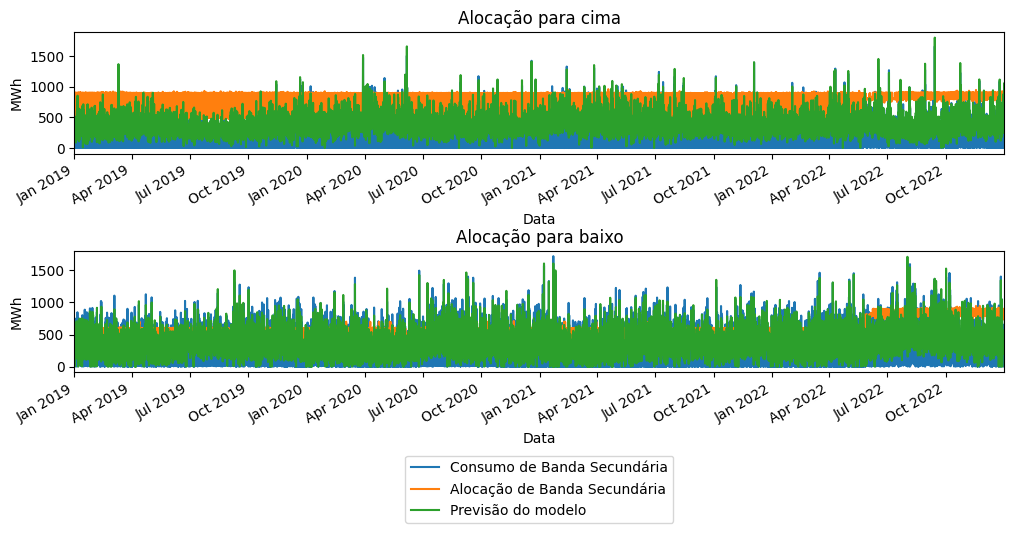

In [18]:
nrows = 2
ncols = 1

count = 0
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))

for alloc, col_names in pairs_dict.items():
    test_col = col_names["test"]
    benchmark_col = col_names["benchmark"]
    prediction_col = col_names["prediction"]

    # Adjust the vertical spacing here
    plt.subplots_adjust(hspace=0.8)
    ax = axis.flatten()[count]

    # Check target distribution
    dataset[test_col].plot(ax=ax, label="Consumo de Banda Secundária")
    dataset[benchmark_col].plot(ax=ax, label="Alocação de Banda Secundária")
    dataset_plot[prediction_col].plot(ax=ax, label="Previsão do modelo")

    alloc_trans = trans_dict[alloc]

    ax.set_title(alloc_trans)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    ax.xaxis.set_major_locator(
        mdates.MonthLocator(interval=3)
    )  # Quarterly intervals
    ax.xaxis.set_major_formatter(
        mdates.DateFormatter("%b %Y")
    )  # Example format: Month Year
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks for each month within the quarter
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))  # Minor tick format: MM

    # Set x-axis label to "Ano"
    ax.set_xlabel("Data")
    # Set y-axis label to "MWh"
    ax.set_ylabel("MWh")
    start_year, end_year = dataset_plot["Year"].min(), dataset_plot.index.max()
    ax.set_xlim(start_year, end_year)
    count += 1

plt.legend(bbox_to_anchor=(0.5, -1.3), loc="lower center")

# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(folder_figures, "alocacoes_finais.png"), bbox_inches="tight"
)

In [19]:
dataset_plot["erro_up"] = (
    dataset_plot["UpwardUsedSecondaryReserveEnergy"]
    - dataset_plot["UpwardPrediction"]
)
dataset_plot["erro_up_per"] = (
    dataset_plot["erro_up"] / dataset_plot["UpwardUsedSecondaryReserveEnergy"]
) * 100
dataset_plot["erro_down"] = (
    dataset_plot["DownwardUsedSecondaryReserveEnergy"]
    - dataset_plot["DownwardPrediction"]
)
dataset_plot["erro_down_per"] = (
    dataset_plot["erro_down"]
    / dataset_plot["DownwardUsedSecondaryReserveEnergy"]
) * 100

dataset_plot["erro_up_stats"] = (
    dataset_plot["UpwardUsedSecondaryReserveEnergy"]
    - dataset_plot["UpwardPrediction_stats"]
)
dataset_plot["erro_up_per_stats"] = (
    dataset_plot["erro_up_stats"]
    / dataset_plot["UpwardUsedSecondaryReserveEnergy"]
) * 100
dataset_plot["erro_down_stats"] = (
    dataset_plot["DownwardUsedSecondaryReserveEnergy"]
    - dataset_plot["DownwardPrediction_stats"]
)
dataset_plot["erro_down_per_stats"] = (
    dataset_plot["erro_down_stats"]
    / dataset_plot["DownwardUsedSecondaryReserveEnergy"]
) * 100


dataset_plot["erro_up_abs"] = dataset_plot["erro_up"].abs()
dataset_plot["erro_down_abs"] = dataset_plot["erro_down"].abs()

dataset_plot["erro_up_abs_stats"] = dataset_plot["erro_up_stats"].abs()
dataset_plot["erro_down_abs_stats"] = dataset_plot["erro_down_stats"].abs()


dataset_plot["erro_up_benchmark"] = (
    dataset_plot["UpwardUsedSecondaryReserveEnergy"]
    - dataset_plot["SecondaryReserveAllocationAUpward"]
)
dataset_plot["erro_down_benchmark"] = (
    dataset_plot["DownwardUsedSecondaryReserveEnergy"]
    - dataset_plot["SecondaryReserveAllocationADownward"]
)
dataset_plot["erro_up_benchmark_abs"] = dataset_plot["erro_up_benchmark"].abs()
dataset_plot["erro_down_benchmark_abs"] = dataset_plot[
    "erro_down_benchmark"
].abs()


dataset_plot["DownAllocF"] = 0.0
dataset_plot["DownAllocD"] = 0.0
dataset_plot["DownAllocF_stats"] = 0.0
dataset_plot["DownAllocD_stats"] = 0.0

dataset_plot["DownBenchmarkAllocF"] = 0.0
dataset_plot["DownBenchmarkAllocD"] = 0.0
dataset_plot["UpAllocF"] = 0.0
dataset_plot["UpAllocD"] = 0.0
dataset_plot["UpAllocF_stats"] = 0.0
dataset_plot["UpAllocD_stats"] = 0.0

dataset_plot["UpBenchmarkAllocF"] = 0.0
dataset_plot["UpBenchmarkAllocD"] = 0.0


mising_mask_up = dataset_plot["erro_up"] > 0
surplus_mask_up = dataset_plot["erro_up"] < 0
mising_mask_up_stats = dataset_plot["erro_up_stats"] > 0
surplus_mask_up_stats = dataset_plot["erro_up_stats"] < 0

mising_mask_benchmark_up = dataset_plot["erro_up_benchmark"] > 0
surplus_mask_benchmark_up = dataset_plot["erro_up_benchmark"] < 0

mising_mask_down = dataset_plot["erro_down"] > 0
surplus_mask_down = dataset_plot["erro_down"] < 0
mising_mask_down_stats = dataset_plot["erro_down_stats"] > 0
surplus_mask_down_stats = dataset_plot["erro_down_stats"] < 0

mising_mask_benchmark_down = dataset_plot["erro_down_benchmark"] > 0
surplus_mask_benchmark_down = dataset_plot["erro_down_benchmark"] < 0


dataset_plot.loc[mising_mask_down, "DownAllocF"] = dataset_plot.loc[
    mising_mask_down, "erro_down_abs"
]
dataset_plot.loc[surplus_mask_down, "DownAllocD"] = dataset_plot.loc[
    surplus_mask_down, "erro_down_abs"
]
dataset_plot.loc[mising_mask_up, "UpAllocF"] = dataset_plot.loc[
    mising_mask_up, "erro_up_abs"
]
dataset_plot.loc[surplus_mask_up, "UpAllocD"] = dataset_plot.loc[
    surplus_mask_up, "erro_up_abs"
]


dataset_plot.loc[mising_mask_down_stats, "DownAllocF_stats"] = (
    dataset_plot.loc[mising_mask_down_stats, "erro_down_abs_stats"]
)
dataset_plot.loc[surplus_mask_down_stats, "DownAllocD_stats"] = (
    dataset_plot.loc[surplus_mask_down_stats, "erro_down_abs_stats"]
)
dataset_plot.loc[mising_mask_up_stats, "UpAllocF_stats"] = dataset_plot.loc[
    mising_mask_up_stats, "erro_up_abs_stats"
]
dataset_plot.loc[surplus_mask_up_stats, "UpAllocD_stats"] = dataset_plot.loc[
    surplus_mask_up_stats, "erro_up_abs_stats"
]


dataset_plot.loc[mising_mask_benchmark_down, "DownBenchmarkAllocF"] = (
    dataset_plot.loc[mising_mask_benchmark_down, "erro_down_benchmark_abs"]
)
dataset_plot.loc[surplus_mask_benchmark_down, "DownBenchmarkAllocD"] = (
    dataset_plot.loc[surplus_mask_benchmark_down, "erro_down_benchmark_abs"]
)
dataset_plot.loc[mising_mask_benchmark_up, "UpBenchmarkAllocF"] = (
    dataset_plot.loc[mising_mask_benchmark_up, "erro_up_benchmark_abs"]
)
dataset_plot.loc[surplus_mask_benchmark_up, "UpBenchmarkAllocD"] = (
    dataset_plot.loc[surplus_mask_benchmark_up, "erro_up_benchmark_abs"]
)


dataset_plot["erro_up_benchmark_per"] = (
    dataset_plot["erro_up_benchmark"]
    / dataset_plot["UpwardUsedSecondaryReserveEnergy"]
) * 100
dataset_plot["erro_down_benchmark_per"] = (
    dataset_plot["erro_down_benchmark"]
    / dataset_plot["DownwardUsedSecondaryReserveEnergy"]
) * 100

upzeromask = dataset_plot["UpwardUsedSecondaryReserveEnergy"] == 0
downzeromask = dataset_plot["DownwardUsedSecondaryReserveEnergy"] == 0


dataset_plot.loc[upzeromask, "erro_up_benchmark_per"] = (
    (dataset_plot.loc[upzeromask, "erro_up_benchmark"] + 1)
    / (dataset_plot.loc[upzeromask, "UpwardUsedSecondaryReserveEnergy"] + 1)
) * 100
dataset_plot.loc[upzeromask, "erro_up_per"] = (
    (dataset_plot.loc[upzeromask, "erro_up"] + 1)
    / (dataset_plot.loc[upzeromask, "UpwardUsedSecondaryReserveEnergy"] + 1)
) * 100

dataset_plot.loc[downzeromask, "erro_down_benchmark_per"] = (
    (dataset_plot.loc[downzeromask, "erro_down_benchmark"] + 1)
    / (
        dataset_plot.loc[downzeromask, "DownwardUsedSecondaryReserveEnergy"]
        + 1
    )
) * 100
dataset_plot.loc[downzeromask, "erro_down_per"] = (
    (dataset_plot.loc[downzeromask, "erro_down"] + 1)
    / (
        dataset_plot.loc[downzeromask, "DownwardUsedSecondaryReserveEnergy"]
        + 1
    )
) * 100

In [20]:
def get_best_period_on_dataframe(df, metric, biggest=False, period="1ME"):
    sampling_means = df.resample(period)[metric].mean()
    if biggest:
        opt_index_end = sampling_means.idxmax()
    else:
        opt_index_end = sampling_means.idxmin()

    opt_index_start = sampling_means[:opt_index_end].iloc[-2:].index[0]
    return opt_index_start, opt_index_end

In [21]:
def metric_scores_renewtese(name, predictions, truth_data, benchmark=False):
    erro = truth_data - predictions
    erro_abs = np.abs(erro)
    erro_abs_sum = np.nansum(erro_abs)

    mse = np.nanmean(np.square(erro))
    rmse = np.sqrt(mse)

    erro_benchmark = truth_data - benchmark
    erro_benchmark_abs = np.abs(erro_benchmark)
    erro_benchmark_abs_sum = np.nansum(erro_benchmark_abs)

    erro_benchmark_mse = np.nanmean(np.square(erro_benchmark))
    erro_benchmark_rmse = np.sqrt(erro_benchmark_mse)

    surplus_mask = erro < 0
    missing_mask = erro > 0
    surplus_mask_benchmark = erro_benchmark < 0
    missing_mask_benchmark = erro_benchmark > 0

    abs_better_than_benchmark_mask = erro_benchmark_abs < erro_abs

    alloc_missing = np.where(
        predictions > truth_data, 0, truth_data - predictions
    )
    alloc_surplus = np.where(
        predictions < truth_data, 0, predictions - truth_data
    )

    benchmark_alloc_missing = np.where(
        benchmark > truth_data, 0, truth_data - benchmark
    )
    benchmark_alloc_surplus = np.where(
        benchmark < truth_data, 0, benchmark - truth_data
    )

    smaller_error = erro_abs < erro_benchmark_abs

    mask_great_or_equal = predictions >= truth_data

    optimal_mask = mask_great_or_equal & smaller_error
    optimal_percentage = (np.sum(optimal_mask) / truth_data.size) * 100

    benchmark_alloc_missing_sum = np.sum(benchmark_alloc_missing)
    benchmark_alloc_surplus_sum = np.sum(benchmark_alloc_surplus)

    alloc_missing_sum = np.sum(alloc_missing)
    alloc_surplus_sum = np.sum(alloc_surplus)

    GPD_total = (
        (erro_benchmark_abs_sum - erro_abs_sum) / (erro_benchmark_abs_sum)
    ) * 100
    GPD_F_total = (
        (benchmark_alloc_missing_sum - alloc_missing_sum)
        / (benchmark_alloc_missing_sum)
    ) * 100
    GPD_D_total = (
        (benchmark_alloc_surplus_sum - alloc_surplus_sum)
        / (benchmark_alloc_surplus_sum)
    ) * 100
    GPD_norm_total = np.mean([GPD_D_total, GPD_F_total])

    missing_smaller = alloc_missing_sum < benchmark_alloc_missing_sum
    surplus_smaller = alloc_surplus_sum < benchmark_alloc_surplus_sum

    better_than_benchmark = missing_smaller & surplus_smaller

    if better_than_benchmark:
        GPD_positivo_total = GPD_total
    else:
        GPD_positivo_total = 0

    GPD_D_form2_total = GPD_D_total
    GPD_F_form2_total = GPD_F_total
    if GPD_D_form2_total < 0:
        GPD_D_form2_total = (GPD_D_form2_total**2) * -1
    if GPD_F_form2_total < 0:
        GPD_F_form2_total = (GPD_F_form2_total**2) * -1
    GPD_norm2_total = np.mean([GPD_D_form2_total, GPD_F_form2_total])

    delta_erros = erro_benchmark - erro
    sum_erros = erro_benchmark + erro
    GPD = ((erro_benchmark_abs - erro_abs) / (erro_benchmark_abs)) * 100

    GPD_D = np.full(truth_data.shape, np.nan)
    GPD_F = np.full(truth_data.shape, np.nan)
    zero_mask = erro == 0
    GPD_D[zero_mask] = 100
    GPD_F[zero_mask] = 100

    GPD_D[surplus_mask_benchmark] = GPD[surplus_mask_benchmark]
    GPD_F[missing_mask_benchmark] = GPD[missing_mask_benchmark]

    GPD_norm = np.nanmean([GPD_D, GPD_F], axis=0)

    GPD_D_fornorm2 = GPD_D.copy()
    GPD_F_fornorm2 = GPD_F.copy()
    GPD_D_fornorm2[GPD_D_fornorm2 < 0] = (
        (GPD_D_fornorm2[GPD_D_fornorm2 < 0] - 1) ** 2
    ) * -1
    GPD_F_fornorm2[GPD_F_fornorm2 < 0] = (
        (GPD_F_fornorm2[GPD_F_fornorm2 < 0] - 1) ** 2
    ) * -1
    GPD_norm2 = np.nanmean([GPD_D_fornorm2, GPD_F_fornorm2], axis=0)

    better_when_surplus = GPD_D > 0
    better_when_missing = GPD_F > 0
    both_better = better_when_surplus & better_when_missing

    GPD_positivo = GPD.copy()
    GPD_positivo[~both_better] = 0

    GPD_all_positive = 0
    GPD_all_positive_total = 0

    if GPD_positivo_total > 0:
        if np.nanmean(GPD_positivo) > 0:
            if np.nanmean(GPD_D) > 0:
                if np.nanmean(GPD_F) > 0:
                    GPD_all_positive = np.nanmean(GPD_positivo)
                    GPD_all_positive_total = GPD_positivo_total

    predict_score = {
        "name": [name],
        "RMSE": [rmse],
        "SAE": [erro_abs_sum],
        "AllocF": [alloc_missing_sum],
        "AllocD": [alloc_surplus_sum],
        "GPD F": [GPD_F_total],
        "GPD D": [GPD_D_total],
        "GPD": [GPD_total],
        "GPD norm": [GPD_norm_total],
        "GPD Positivo": [GPD_positivo_total],
        "GPD norm2": [GPD_norm2_total],
        "OptPer": [optimal_percentage],
        "benchmark SAE": [erro_benchmark_abs_sum],
        "benchmark rmse": [erro_benchmark_rmse],
        "benchmark AllocF": [benchmark_alloc_missing_sum],
        "benchmark AllocD": [benchmark_alloc_surplus_sum],
        "GPD medio": [np.nanmean(GPD)],
        "GPD D medio": [np.nanmean(GPD_D)],
        "GPD F medio": [np.nanmean(GPD_F)],
        "GPD norm medio": [np.nanmean(GPD_norm)],
        "GPD norm2 medio": [np.nanmean(GPD_norm2)],
        "GPD Positivo medio": [np.nanmean(GPD_positivo)],
        "GPD_all_positive": [GPD_all_positive],
        "GPD_all_positive_total": [GPD_all_positive_total],
    }

    return predict_score

In [22]:
def get_gpds(
    dataset_timeframe,
    metric="up",
    total_in_timeframe=True,
    metric_gpd=None,
    metric_gpd_positivo=None,
    erro_benchmark_abs_metric=None,
    erro_abs_metric=None,
    erro_benchmark_metric=None,
    erro_metric=None,
    stats_models=False,
):
    metric_gpd = metric_gpd or f"GPD {metric}"
    metric_gpd_positivo = metric_gpd_positivo or f"GPD Positivo {metric}"
    erro_benchmark_abs_metric = (
        erro_benchmark_abs_metric or f"erro_{metric}_benchmark_abs"
    )
    erro_abs_metric = erro_abs_metric or f"erro_{metric}_abs"
    erro_benchmark_metric = erro_benchmark_metric or f"erro_{metric}_benchmark"
    erro_metric = erro_metric or f"erro_{metric}"
    if stats_models:
        erro_abs_metric = f"{erro_abs_metric}_stats"
        erro_metric = f"{erro_metric}_stats"

    dataset_timeframe = dataset_timeframe[
        [
            erro_benchmark_abs_metric,
            erro_abs_metric,
            erro_benchmark_metric,
            erro_metric,
        ]
    ]

    if total_in_timeframe:
        dataset_timeframe = dataset_timeframe.sum().to_frame().T

    dataset_timeframe[metric_gpd] = (
        (
            dataset_timeframe[erro_benchmark_abs_metric]
            - dataset_timeframe[erro_abs_metric]
        )
        / dataset_timeframe[erro_benchmark_abs_metric]
    ) * 100
    dataset_timeframe[metric_gpd_positivo] = dataset_timeframe[metric_gpd]

    better_error = (
        dataset_timeframe[erro_benchmark_abs_metric]
        > dataset_timeframe[erro_abs_metric]
    )

    dataset_timeframe.loc[~better_error, metric_gpd_positivo] = 0

    mising_mask = dataset_timeframe[erro_metric] > 0
    surplus_mask = dataset_timeframe[erro_metric] < 0
    mising_mask_benchmark = dataset_timeframe[erro_benchmark_metric] > 0
    surplus_mask_benchmark = dataset_timeframe[erro_benchmark_metric] < 0

    both_missing = mising_mask & mising_mask_benchmark
    both_surplus = surplus_mask & surplus_mask_benchmark

    missing_smaller = both_missing & better_error
    surplus_smaller = both_surplus & better_error
    better_than_benchmark = missing_smaller | surplus_smaller

    dataset_timeframe.loc[~better_than_benchmark, metric_gpd_positivo] = 0
    dataset_timeframe.loc[
        dataset_timeframe[erro_metric] == 0, metric_gpd_positivo
    ] = 100

    return dataset_timeframe

In [23]:
def get_best_gpd_period_on_dataframe(
    df,
    metric,
    metric_to_sort="GPD",
    biggest=False,
    period="1ME",
    stats_models=False,
):
    sampling_means = df.resample(period)

    metric_to_sort = f"{metric_to_sort} {metric}"
    # Prepare an empty list to hold the results from each period
    results_list = []

    # Iterate over each group (time period) obtained from resampling
    for name, group in sampling_means:
        # Apply get_gpds to each group
        gpds_result = get_gpds(
            group,
            metric=metric,
            total_in_timeframe=True,
            stats_models=stats_models,
        )
        gpds_result["datetime"] = group.index[0]
        gpds_result = gpds_result.set_index("datetime")

        # Append the result to the results_list
        results_list.append(gpds_result)

    # Combine the results into a single DataFrame
    combined_results = pd.concat(
        results_list,  # ignore_index=False
    )
    if biggest:
        opt_index_end = combined_results[metric_to_sort].idxmax()
    else:
        opt_index_end = combined_results[metric_to_sort].idxmin()

    opt_index_start = combined_results[:opt_index_end].iloc[-2:].index[0]
    return opt_index_start, opt_index_end

In [24]:
stats_down_best_month_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD", biggest=True, period="1ME", stats_models=True
)
stats_down_best_week_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD", biggest=True, period="1W", stats_models=True
)
stats_down_best_day_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD", biggest=True, period="1D", stats_models=True
)
stats_down_worst_month_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD", biggest=False, period="1ME", stats_models=True
)
stats_down_worst_week_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD", biggest=False, period="1W", stats_models=True
)
stats_down_worst_day_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD", biggest=False, period="1D", stats_models=True
)
stats_up_best_month_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD", biggest=True, period="1ME", stats_models=True
)
stats_up_best_week_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD", biggest=True, period="1W", stats_models=True
)
stats_up_best_day_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD", biggest=True, period="1D", stats_models=True
)
stats_up_worst_month_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD", biggest=False, period="1ME", stats_models=True
)
stats_up_worst_week_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD", biggest=False, period="1W", stats_models=True
)
stats_up_worst_day_GPD = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD", biggest=False, period="1D", stats_models=True
)
stats_couples_down_GPD = [
    [stats_down_best_month_GPD, stats_down_worst_month_GPD],
    [stats_down_best_week_GPD, stats_down_worst_week_GPD],
    [stats_down_best_day_GPD, stats_down_worst_day_GPD],
]
stats_couples_up_GPD = [
    [stats_up_best_month_GPD, stats_up_worst_month_GPD],
    [stats_up_best_week_GPD, stats_up_worst_week_GPD],
    [stats_up_best_day_GPD, stats_up_worst_day_GPD],
]

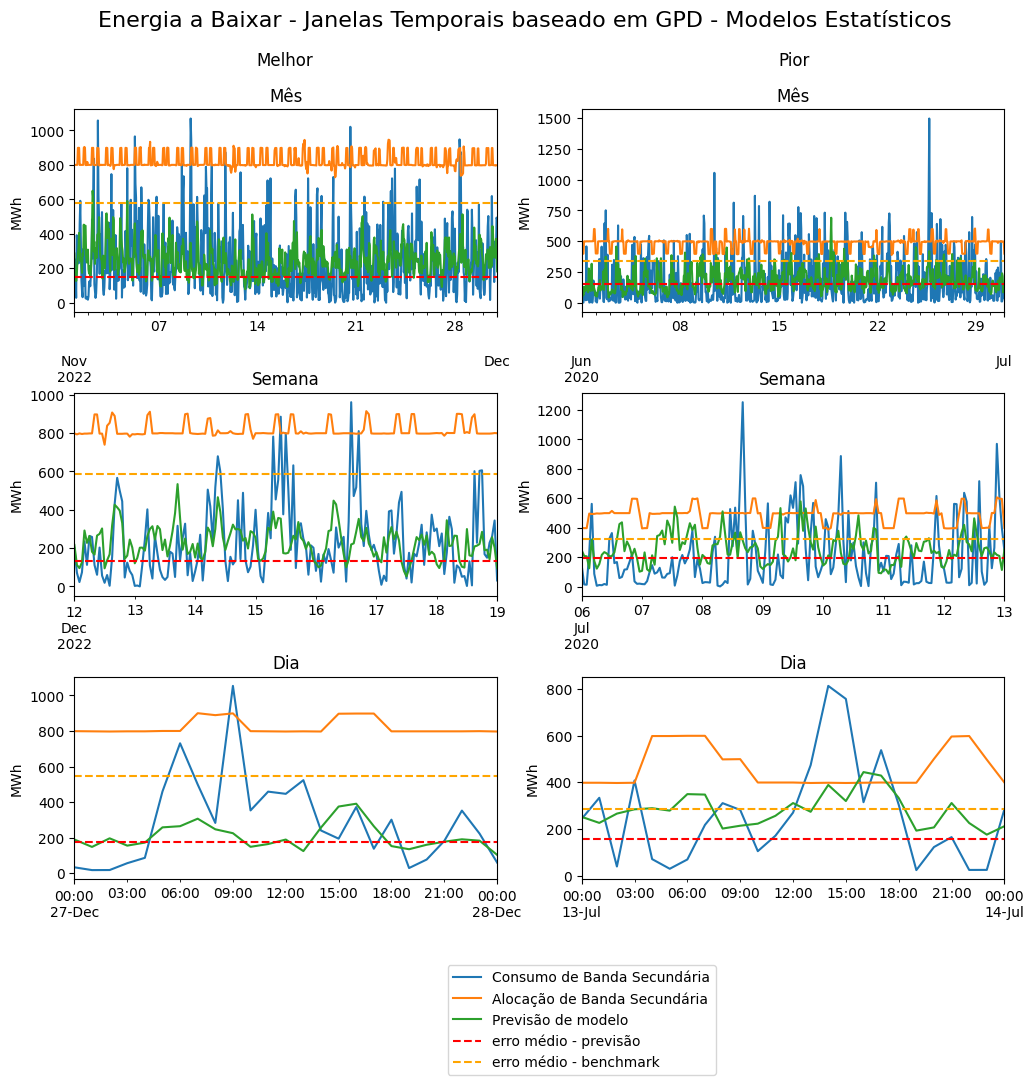

In [25]:
couples_list = stats_couples_down_GPD
truth_metric = "DownwardUsedSecondaryReserveEnergy"
benchmark_metric = "SecondaryReserveAllocationADownward"
prediction_metric = "DownwardPrediction_stats"
error_metric = "erro_down_abs_stats"
error_metric_benchmark = "erro_down_benchmark_abs"

time_periods = ["Mês", "Semana", "Dia"]
column_titles = ["Melhor", "Pior"]  # Customize these titles as needed
nrows = 3
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_per in enumerate(couples_list):
    for c, tf in enumerate(time_per):
        start, end = tf
        ax = axis[r, c]
        dataset_plot_time_range = dataset_plot[start:end]
        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        dataset_plot_time_range[prediction_metric].plot(
            ax=axis[r, c], label="Previsão de modelo"
        )

        ax.axhline(
            y=dataset_plot_time_range[error_metric].mean(),
            color="red",
            linestyle="--",
            label="erro médio - previsão",
        )
        ax.axhline(
            y=dataset_plot_time_range[error_metric_benchmark].mean(),
            color="orange",
            linestyle="--",
            label="erro médio - benchmark",
        )

        plt.subplots_adjust(hspace=0.4)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -1), loc="lower center")
fig.suptitle(
    "Energia a Baixar - Janelas Temporais baseado em GPD - Modelos Estatísticos",
    fontsize=16,
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(
        folder_figures, "alocacoes_temporais_downward_prediction_gpd_stats.png"
    ),
    bbox_inches="tight",
)

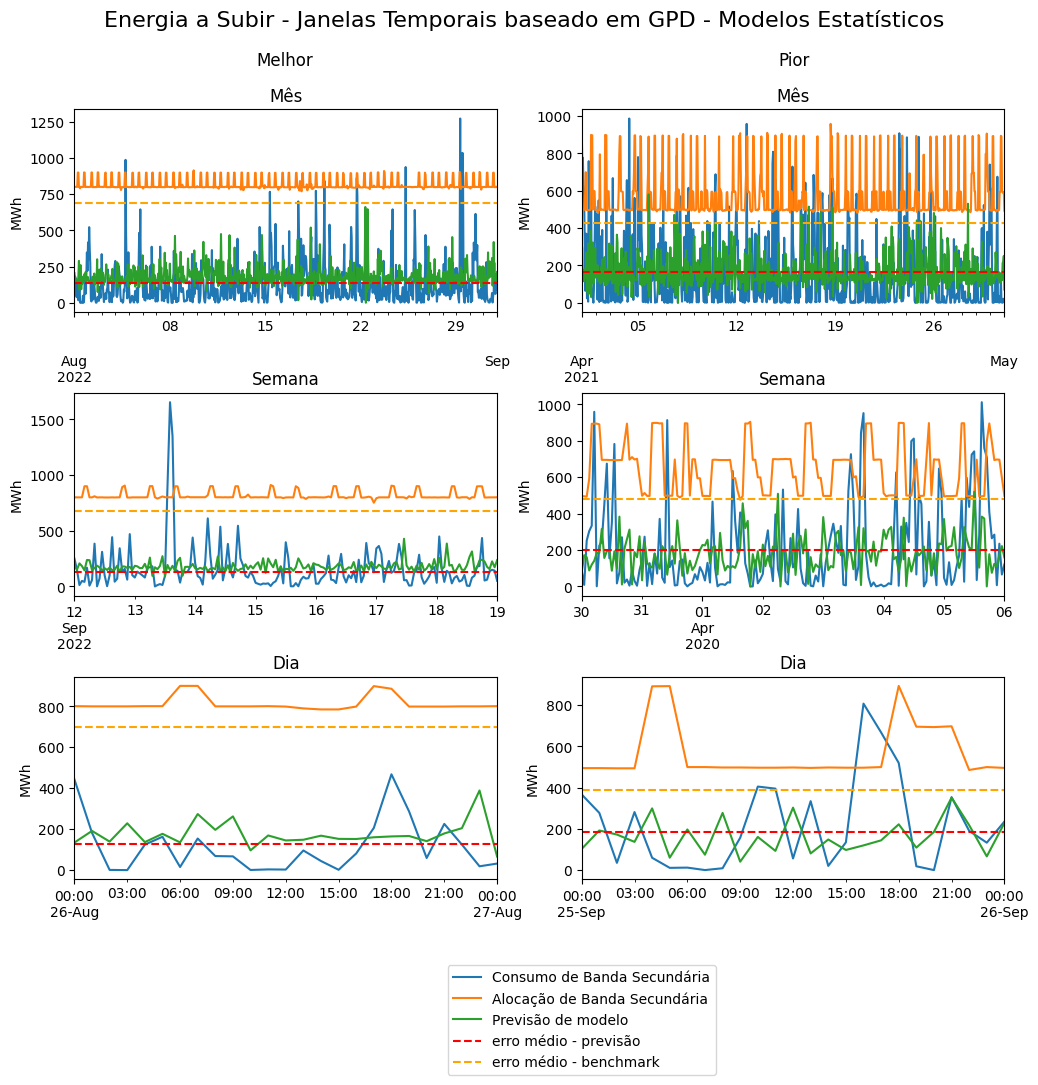

In [26]:
couples_list = stats_couples_up_GPD
truth_metric = "UpwardUsedSecondaryReserveEnergy"
benchmark_metric = "SecondaryReserveAllocationAUpward"
error_metric_benchmark = "erro_up_benchmark_abs"
prediction_metric = "UpwardPrediction_stats"
error_metric = "erro_up_abs_stats"

time_periods = ["Mês", "Semana", "Dia"]
column_titles = ["Melhor", "Pior"]  # Customize these titles as needed
nrows = 3
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_per in enumerate(couples_list):
    for c, tf in enumerate(time_per):
        start, end = tf
        ax = axis[r, c]
        dataset_plot_time_range = dataset_plot[start:end]
        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        dataset_plot_time_range[prediction_metric].plot(
            ax=axis[r, c], label="Previsão de modelo"
        )

        ax.axhline(
            y=dataset_plot_time_range[error_metric].mean(),
            color="red",
            linestyle="--",
            label="erro médio - previsão",
        )
        ax.axhline(
            y=dataset_plot_time_range[error_metric_benchmark].mean(),
            color="orange",
            linestyle="--",
            label="erro médio - benchmark",
        )

        plt.subplots_adjust(hspace=0.4)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -1), loc="lower center")
fig.suptitle(
    "Energia a Subir - Janelas Temporais baseado em GPD - Modelos Estatísticos",
    fontsize=16,
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(
        folder_figures, "alocacoes_temporais_upward_prediction_gpd_stats.png"
    ),
    bbox_inches="tight",
)

In [27]:
down_best_month_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD Positivo", biggest=True, period="1ME"
)
down_best_week_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD Positivo", biggest=True, period="1W"
)
down_best_day_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD Positivo", biggest=True, period="1D"
)
down_worst_month_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD Positivo", biggest=False, period="1ME"
)
down_worst_week_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD Positivo", biggest=False, period="1W"
)
down_worst_day_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "down", "GPD Positivo", biggest=False, period="1D"
)
up_best_month_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD Positivo", biggest=True, period="1ME"
)
up_best_week_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD Positivo", biggest=True, period="1W"
)
up_best_day_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD Positivo", biggest=True, period="1D"
)
up_worst_month_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD Positivo", biggest=False, period="1ME"
)
up_worst_week_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD Positivo", biggest=False, period="1W"
)
up_worst_day_GPD_Positivo = get_best_gpd_period_on_dataframe(
    dataset_plot, "up", "GPD Positivo", biggest=False, period="1D"
)
couples_down_GPD_Positivo = [
    [down_best_month_GPD_Positivo, down_worst_month_GPD_Positivo],
    [down_best_week_GPD_Positivo, down_worst_week_GPD_Positivo],
    [down_best_day_GPD_Positivo, down_worst_day_GPD_Positivo],
]
couples_up_GPD_Positivo = [
    [up_best_month_GPD_Positivo, up_worst_month_GPD_Positivo],
    [up_best_week_GPD_Positivo, up_worst_week_GPD_Positivo],
    [up_best_day_GPD_Positivo, up_worst_day_GPD_Positivo],
]

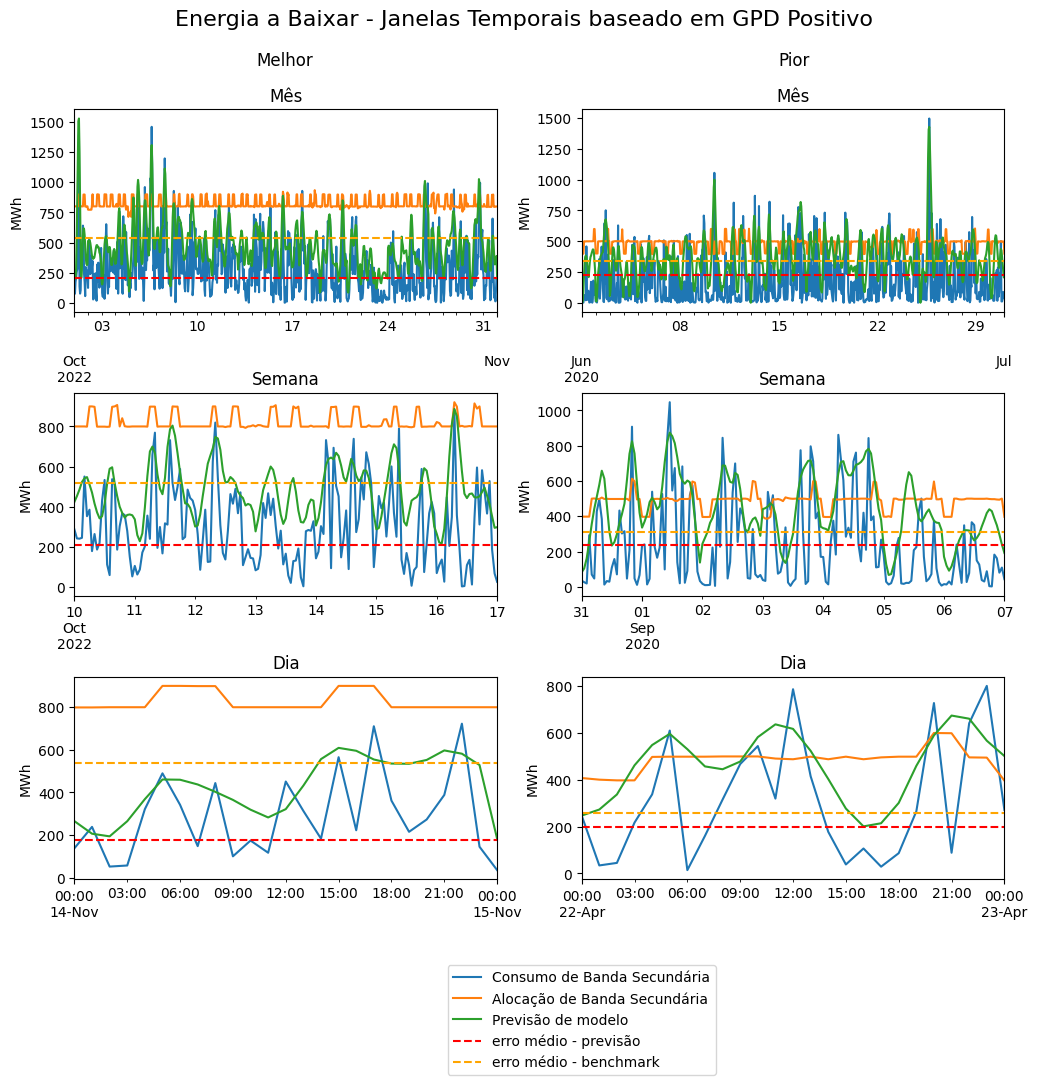

In [28]:
couples_list = couples_down_GPD_Positivo
truth_metric = "DownwardUsedSecondaryReserveEnergy"
benchmark_metric = "SecondaryReserveAllocationADownward"
prediction_metric = "DownwardPrediction"
error_metric = "erro_down_abs"
error_metric_benchmark = "erro_down_benchmark_abs"

time_periods = ["Mês", "Semana", "Dia"]
column_titles = ["Melhor", "Pior"]  # Customize these titles as needed
nrows = 3
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_per in enumerate(couples_list):
    for c, tf in enumerate(time_per):
        start, end = tf
        ax = axis[r, c]
        dataset_plot_time_range = dataset_plot[start:end]
        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        dataset_plot_time_range[prediction_metric].plot(
            ax=axis[r, c], label="Previsão de modelo"
        )

        ax.axhline(
            y=dataset_plot_time_range[error_metric].mean(),
            color="red",
            linestyle="--",
            label="erro médio - previsão",
        )
        ax.axhline(
            y=dataset_plot_time_range[error_metric_benchmark].mean(),
            color="orange",
            linestyle="--",
            label="erro médio - benchmark",
        )

        plt.subplots_adjust(hspace=0.4)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -1), loc="lower center")
fig.suptitle(
    "Energia a Baixar - Janelas Temporais baseado em GPD Positivo", fontsize=16
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(
        folder_figures, "alocacoes_temporais_downward_prediction_gpd_p.png"
    ),
    bbox_inches="tight",
)

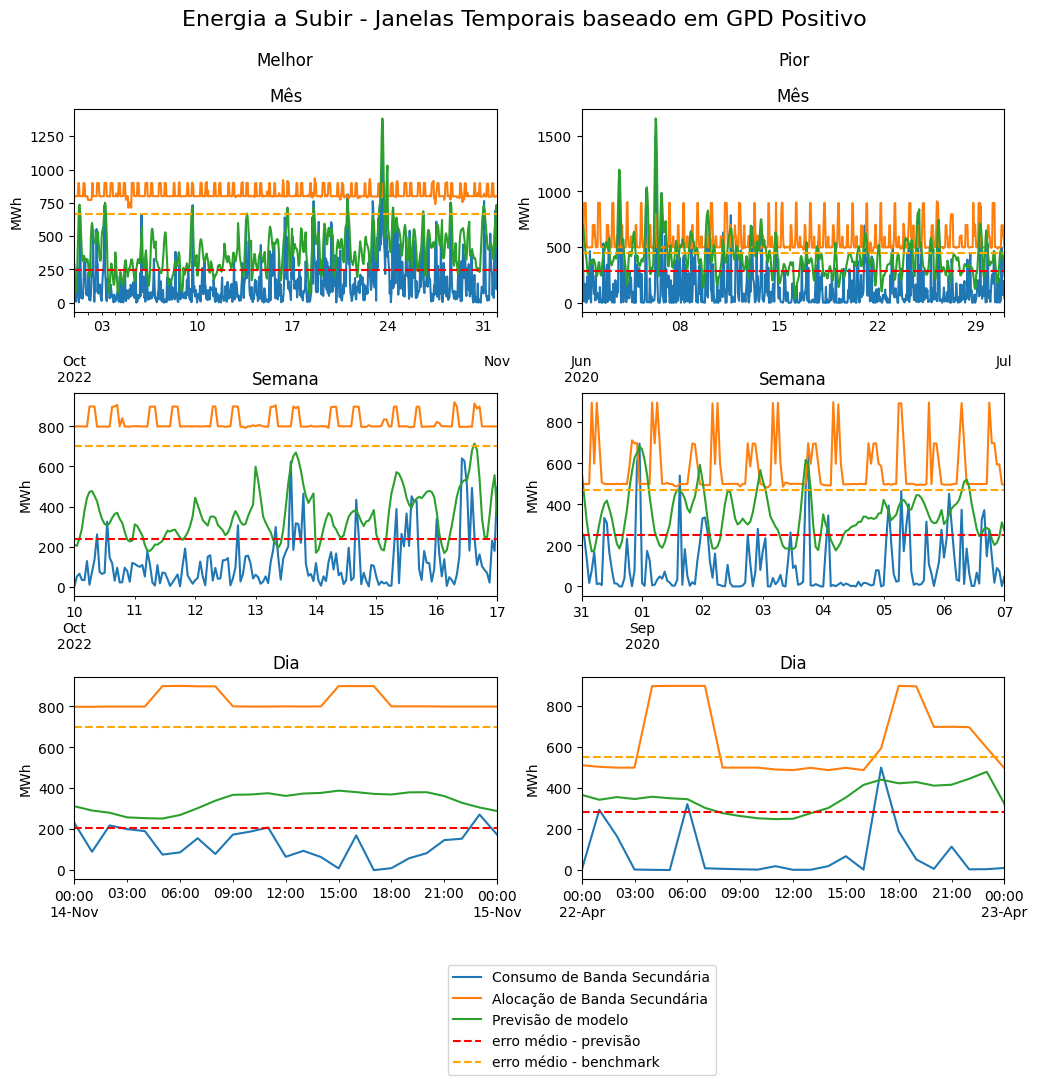

In [29]:
couples_list = couples_down_GPD_Positivo
truth_metric = "UpwardUsedSecondaryReserveEnergy"
benchmark_metric = "SecondaryReserveAllocationAUpward"
error_metric_benchmark = "erro_up_benchmark_abs"
prediction_metric = "UpwardPrediction"
error_metric = "erro_up_abs"

time_periods = ["Mês", "Semana", "Dia"]
column_titles = ["Melhor", "Pior"]  # Customize these titles as needed
nrows = 3
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_per in enumerate(couples_list):
    for c, tf in enumerate(time_per):
        start, end = tf
        ax = axis[r, c]
        dataset_plot_time_range = dataset_plot[start:end]
        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        dataset_plot_time_range[prediction_metric].plot(
            ax=axis[r, c], label="Previsão de modelo"
        )

        ax.axhline(
            y=dataset_plot_time_range[error_metric].mean(),
            color="red",
            linestyle="--",
            label="erro médio - previsão",
        )
        ax.axhline(
            y=dataset_plot_time_range[error_metric_benchmark].mean(),
            color="orange",
            linestyle="--",
            label="erro médio - benchmark",
        )

        plt.subplots_adjust(hspace=0.4)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -1), loc="lower center")
fig.suptitle(
    "Energia a Subir - Janelas Temporais baseado em GPD Positivo", fontsize=16
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(
        folder_figures, "alocacoes_temporais_upward_prediction_gpd_p.png"
    ),
    bbox_inches="tight",
)

In [30]:
cols_for_plot = [
    "DownwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationAUpward",
    "SecondaryReserveAllocationADownward",
    "UpwardUsedSecondaryReserveEnergy",
    "UpwardPrediction_stats",
    "DownwardPrediction_stats",
    "erro_up_per",
    "erro_up_stats",
    "erro_down_per",
    "erro_down_benchmark_per",
    "erro_up_benchmark_per",
    "hour",
    "day",
    "month",
    "year",
    "day_of_year",
    "day_of_week",
    "week_of_year",
    "erro_down_stats",
    "erro_up_abs_stats",
    "erro_down_abs_stats",
    "erro_up_benchmark",
    "erro_down_benchmark",
    "erro_up_benchmark_abs",
    "erro_down_benchmark_abs",
]

In [31]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction_stats",
        "erro_prediction": "erro_up_stats",
        "erro_benchmark": "erro_up_benchmark",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction_stats",
        "erro_prediction": "erro_down_stats",
        "erro_benchmark": "erro_down_benchmark",
    },
}

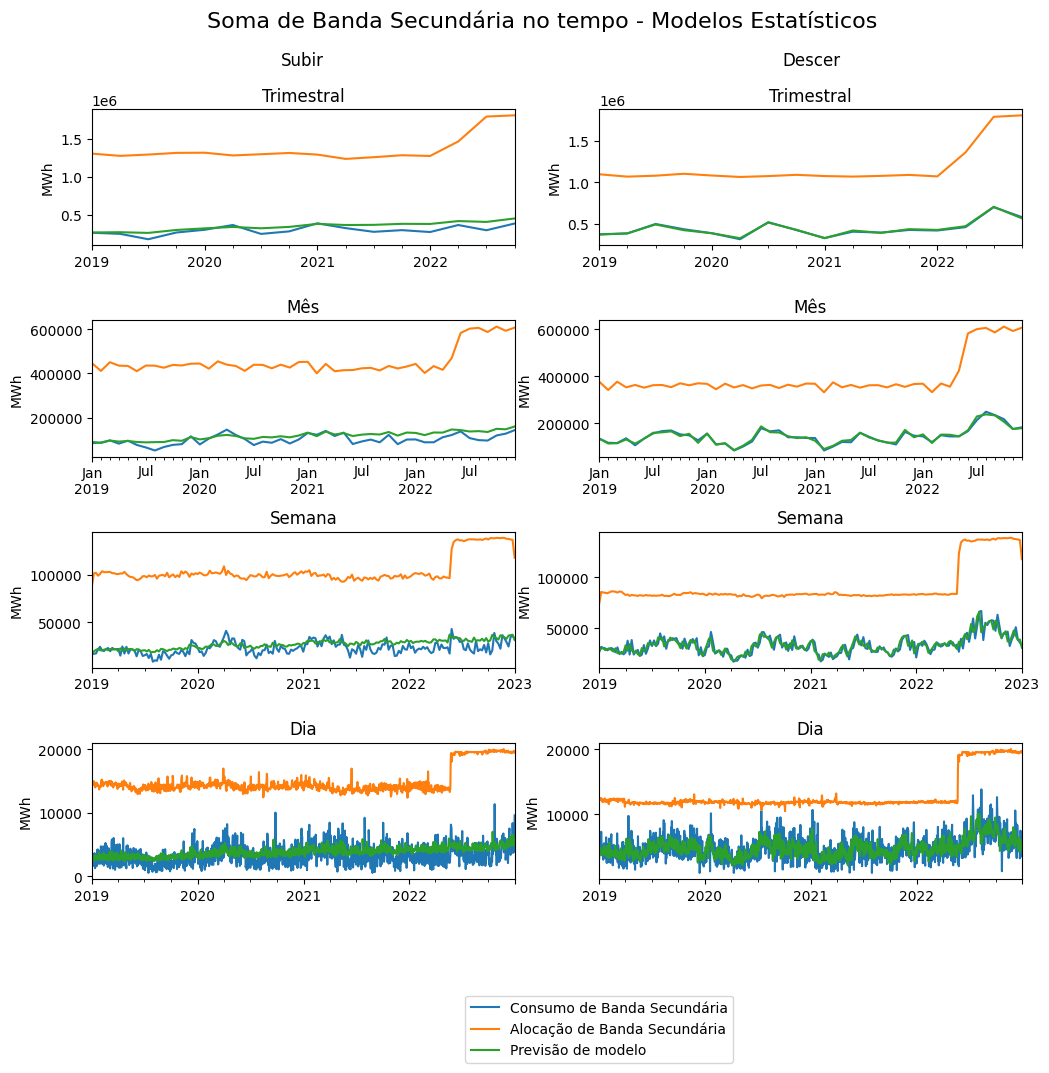

In [32]:
time_periods = ["Trimestral", "Mês", "Semana", "Dia"]
time_periods_resample = ["1QE", "1ME", "1W", "1D"]

column_titles = ["Subir", "Descer"]  # Customize these titles as needed
col_arrow = ["Upward Allocation", "Downward Allocation"]
nrows = len(time_periods_resample)
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_sam in enumerate(time_periods_resample):
    for c, arrow in enumerate(col_arrow):
        ax = axis[r, c]
        dataset_plot_time_range = (
            dataset_plot[cols_for_plot].resample(time_sam).sum()
        )
        col_dict_names = pairs_dict[arrow]
        truth_metric = col_dict_names["test"]
        benchmark_metric = col_dict_names["benchmark"]
        prediction_metric = col_dict_names["prediction"]
        error_metric = col_dict_names["erro_prediction"]
        error_metric_benchmark = col_dict_names["erro_benchmark"]

        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        dataset_plot_time_range[prediction_metric].plot(
            ax=axis[r, c], label="Previsão de modelo"
        )

        # dataset_plot_time_range[error_metric].abs().plot(ax=axis[r,c], label="Erro Modelo")
        # dataset_plot_time_range[error_metric_benchmark].abs().plot(ax=axis[r,c], label="Erro Benchmark")

        # ax.axhline(y=dataset_plot_time_range[error_metric].abs().mean(), color='red', linestyle='--', label='erro médio - previsão')
        # ax.axhline(y=dataset_plot_time_range[error_metric_benchmark].abs().mean(), color='orange', linestyle='--', label='erro médio - benchmark')

        plt.subplots_adjust(hspace=0.55)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -1.4), loc="lower center")
fig.suptitle(
    "Soma de Banda Secundária no tempo - Modelos Estatísticos", fontsize=16
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# fig.savefig("alocation_sum_over_time.png", bbox_inches='tight')
fig.savefig(
    os.path.join(folder_figures, "alocation_sum_over_time_stats.png"),
    bbox_inches="tight",
)

In [33]:
cols_for_plot = [
    "DownwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationAUpward",
    "SecondaryReserveAllocationADownward",
    "UpwardUsedSecondaryReserveEnergy",
    "UpwardPrediction",
    "DownwardPrediction",
    "erro_up_per",
    "erro_up",
    "erro_down_per",
    "erro_down_benchmark_per",
    "erro_up_benchmark_per",
    "hour",
    "day",
    "month",
    "year",
    "day_of_year",
    "day_of_week",
    "week_of_year",
    "erro_down",
    "erro_up_abs",
    "erro_down_abs",
    "erro_up_benchmark",
    "erro_down_benchmark",
    "erro_up_benchmark_abs",
    "erro_down_benchmark_abs",
]

In [34]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction",
        "erro_prediction": "erro_up",
        "erro_benchmark": "erro_up_benchmark",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction",
        "erro_prediction": "erro_down",
        "erro_benchmark": "erro_down_benchmark",
    },
}

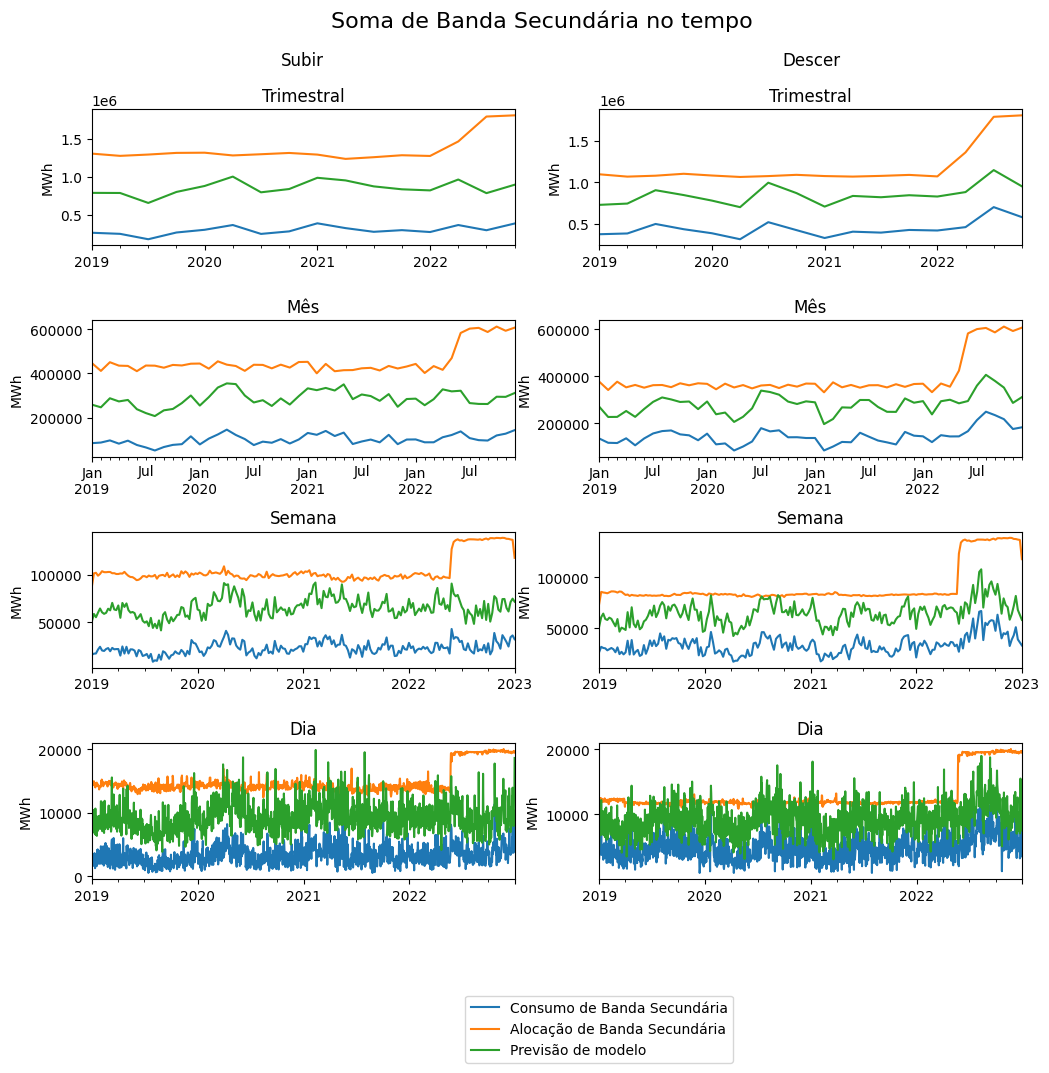

In [35]:
time_periods = ["Trimestral", "Mês", "Semana", "Dia"]
time_periods_resample = ["1QE", "1ME", "1W", "1D"]

column_titles = ["Subir", "Descer"]  # Customize these titles as needed
col_arrow = ["Upward Allocation", "Downward Allocation"]
nrows = len(time_periods_resample)
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_sam in enumerate(time_periods_resample):
    for c, arrow in enumerate(col_arrow):
        ax = axis[r, c]
        dataset_plot_time_range = (
            dataset_plot[cols_for_plot].resample(time_sam).sum()
        )
        col_dict_names = pairs_dict[arrow]
        truth_metric = col_dict_names["test"]
        benchmark_metric = col_dict_names["benchmark"]
        prediction_metric = col_dict_names["prediction"]
        error_metric = col_dict_names["erro_prediction"]
        error_metric_benchmark = col_dict_names["erro_benchmark"]

        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        dataset_plot_time_range[prediction_metric].plot(
            ax=axis[r, c], label="Previsão de modelo"
        )

        # dataset_plot_time_range[error_metric].abs().plot(ax=axis[r,c], label="Erro Modelo")
        # dataset_plot_time_range[error_metric_benchmark].abs().plot(ax=axis[r,c], label="Erro Benchmark")

        # ax.axhline(y=dataset_plot_time_range[error_metric].abs().mean(), color='red', linestyle='--', label='erro médio - previsão')
        # ax.axhline(y=dataset_plot_time_range[error_metric_benchmark].abs().mean(), color='orange', linestyle='--', label='erro médio - benchmark')

        plt.subplots_adjust(hspace=0.55)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -1.4), loc="lower center")
fig.suptitle("Soma de Banda Secundária no tempo", fontsize=16)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# fig.savefig("alocation_sum_over_time.png", bbox_inches='tight')
fig.savefig(
    os.path.join(folder_figures, "alocation_sum_over_time.png"),
    bbox_inches="tight",
)

In [36]:
cols_to_save = [
    "DownwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationAUpward",
    "SecondaryReserveAllocationADownward",
    "UpwardUsedSecondaryReserveEnergy",
    "WindD+1DailyForecast",
    "PhotovoltaicD+1DailyForecast",
    "DemandD+1DailyForecast",
    "TotalBaseDailyOperatingSchedulePBFGeneration",
    "BaseDailyOperatingSchedulePBFSolarPV",
    "BaseDailyOperatingSchedulePBFWind",
    "BaseDailyOperatingShedulePBFTotalBalanceInterconnections",
    "hour",
    "day",
    "month",
    "year",
    "day_of_year",
    "day_of_week",
    "week_of_year",
    "UpwardPrediction",
    "DownwardPrediction",
    "Year",
    "erro_up",
    "erro_down",
    "erro_up_benchmark",
    "erro_down_benchmark",
    "erro_up_benchmark_abs",
    "erro_down_benchmark_abs",
    "GPD up",
    "GPD Positivo up",
    "GPD down",
    "GPD Positivo down",
]

In [37]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction",
        "erro_prediction": "erro_up",
        "erro_benchmark": "erro_up_benchmark",
        "capacity": "UpCapacity",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction",
        "erro_prediction": "erro_down",
        "erro_benchmark": "erro_down_benchmark",
        "capacity": "DownCapacity",
    },
}

In [38]:
meti = "Upward Allocation"
colsi_dict = pairs_dict[meti]
dataset_plot[colsi_dict["capacity"]] = (
    dataset_plot[colsi_dict["benchmark"]] + dataset_plot[colsi_dict["test"]]
)

meti = "Downward Allocation"
colsi_dict = pairs_dict[meti]
dataset_plot[colsi_dict["capacity"]] = (
    dataset_plot[colsi_dict["benchmark"]] + dataset_plot[colsi_dict["test"]]
)

In [39]:
dataset_plot["BenchmarkCapacity"] = (
    dataset_plot["SecondaryReserveAllocationAUpward"]
    + dataset_plot["SecondaryReserveAllocationADownward"]
)
dataset_plot["ModelCapacity"] = (
    dataset_plot["UpwardPrediction"] + dataset_plot["DownwardPrediction"]
)

In [40]:
pairs_dict = {
    "Upward Allocation": {  #'test': 'UpwardUsedSecondaryReserveEnergy',
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction",
        # "capacity":"UpCapacity",
    },
    "Downward Allocation": {  #'test': 'DownwardUsedSecondaryReserveEnergy',
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction",
        # "capacity":"DownCapacity",
    },
}

In [41]:
media = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].mean().to_frame().T
)
media["Análise"] = "média"
desvio = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].std().to_frame().T
)
desvio["Análise"] = "desvio padrão"
minimo = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].min().to_frame().T
)
minimo["Análise"] = "min"
maximo = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].max().to_frame().T
)
maximo["Análise"] = "max"


tabela_subir = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
tabela_subir = tabela_subir[
    ["UpwardPrediction", "SecondaryReserveAllocationAUpward", "Análise"]
]

tabela_subir["a"] = "Análise"
tabela_subir = tabela_subir.set_index(["a", "Análise"])

In [42]:
media = (
    dataset_plot[pairs_dict["Downward Allocation"].values()]
    .mean()
    .to_frame()
    .T
)
media["Análise"] = "média"
desvio = (
    dataset_plot[pairs_dict["Downward Allocation"].values()].std().to_frame().T
)
desvio["Análise"] = "desvio padrão"
minimo = (
    dataset_plot[pairs_dict["Downward Allocation"].values()].min().to_frame().T
)
minimo["Análise"] = "min"
maximo = (
    dataset_plot[pairs_dict["Downward Allocation"].values()].max().to_frame().T
)
maximo["Análise"] = "max"


tabela_descer = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
tabela_descer = tabela_descer[
    ["DownwardPrediction", "SecondaryReserveAllocationADownward", "Análise"]
]
tabela_descer["a"] = "Análise"
tabela_descer = tabela_descer.set_index(["a", "Análise"])

In [43]:
media = (
    dataset_plot[["ModelCapacity", "BenchmarkCapacity"]].mean().to_frame().T
)
media["Análise"] = "média"
desvio = (
    dataset_plot[["ModelCapacity", "BenchmarkCapacity"]].std().to_frame().T
)
desvio["Análise"] = "desvio padrão"
minimo = (
    dataset_plot[["ModelCapacity", "BenchmarkCapacity"]].min().to_frame().T
)
minimo["Análise"] = "min"
maximo = (
    dataset_plot[["ModelCapacity", "BenchmarkCapacity"]].max().to_frame().T
)
maximo["Análise"] = "max"


tabela_capacidade = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
tabela_capacidade = tabela_capacidade[
    ["ModelCapacity", "BenchmarkCapacity", "Análise"]
]
tabela_capacidade["a"] = "Análise"
tabela_capacidade = tabela_capacidade.set_index(["a", "Análise"])

In [44]:
bnchi = "UpBenchmarkAllocF"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_bench_extra_up = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
bnchi = "DownBenchmarkAllocF"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_bench_extra_down = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")

bnchi = "UpAllocF"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_extra_up = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
bnchi = "DownAllocF"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_extra_down = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")

tabela_extra = pd.concat(
    [
        tabela_extra_down.T,
        tabela_extra_up.T,
        tabela_bench_extra_down.T,
        tabela_bench_extra_up.T,
    ]
).T
tabela_extra_anal = tabela_extra["Análise"].T.iloc[:1].T
tabela_extra = tabela_extra[
    ["DownAllocF", "UpAllocF", "DownBenchmarkAllocF", "UpBenchmarkAllocF"]
]
tabela_extra["Análise"] = tabela_extra_anal
tabela_extra["a"] = "Análise"
tabela_extra = tabela_extra.set_index(["a", "Análise"])
# tabela_extra.index.names = [None, None]
# tabela_extra=tabela_extra.T

In [45]:
result_table = pd.concat(
    [tabela_subir, tabela_descer, tabela_capacidade, tabela_extra], axis=1
)
result_table.index.names = [None, None]
result_table = result_table.T

In [46]:
result_table["b"] = [
    "Alocação a Subir (MW)",
    "Alocação a Subir (MW)",
    "Alocação a Descer (MW)",
    "Alocação a Descer (MW)",
    "Capacidade Horária (MW)",
    "Capacidade Horária (MW)",
    "Energia a Descer Extraordinária (MWh)",
    "Energia a Subir Extraordinária (MWh)",
    "Energia a Descer Extraordinária (MWh)",
    "Energia a Subir Extraordinária (MWh)",
]
result_table["c"] = result_table.index.map(
    {
        "SecondaryReserveAllocationAUpward": "benchmark",
        "UpwardPrediction": "modelo",
        "SecondaryReserveAllocationADownward": "benchmark",
        "DownwardPrediction": "modelo",
        "BenchmarkCapacity": "benchmark",
        "ModelCapacity": "modelo",
        "DownBenchmarkAllocF": "benchmark",
        "DownAllocF": "modelo",
        "UpBenchmarkAllocF": "benchmark",
        "UpAllocF": "modelo",
    }
)
result_table_alone = result_table.set_index(["b", "c"])
result_table = result_table.set_index(["b"])
# result_table=result_table.set_index(["b", "c"])

result_table_alone.index.names = [None, None]
result_table_alone.columns = result_table_alone.columns.droplevel(0)

In [88]:
result_table_alone.sort_index()

média desvio padrão  \
Alocação a Descer (MW)                benchmark   542.585779     126.08638   
                                      modelo      387.281036    189.228989   
Alocação a Subir (MW)                 benchmark   623.679636    152.388896   
                                      modelo      391.308319    157.079559   
Capacidade Horária (MW)               benchmark  1166.265415    250.185243   
                                      modelo      778.589355    213.684311   
Energia a Descer Extraordinária (MWh) benchmark   169.926099    153.950951   
                                      modelo        82.20293     60.795421   
Energia a Subir Extraordinária (MWh)  benchmark   139.305657    136.446529   
                                      modelo       56.459123     41.461051   

                                                        min          max  
Alocação a Descer (MW)                benchmark       363.0        946.0  
                                      modelo            0.0  1711.801514  
Alocação a Subir (MW)                 benchmark       419.0        958.0  
                                      modelo            0.0  1797.192383  
Capacidade Horária (MW)               benchmark       816.0       1891.0  
                                      modelo     174.853287  2281.040039  
Energia a Descer Extraordinária (MWh) benchmark         0.1       1226.4  
                                      modelo       0.005554   333.506982  
Energia a Subir Extraordinária (MWh)  benchmark         0.4        922.8  
                                      modelo       0.028941   212.125757

In [89]:
result_table_alone.sort_index().to_latex(
    os.path.join(folder_tables, "tabela_modelos_res.tex"),
    escape=False,  # index=False,
    float_format="%.2f",
)

In [90]:
def calc_percentage_diff(row):
    model_mean = row.iloc[0:]["Análise"]["média"].iloc[0]
    benchmark_mean = row.iloc[0:]["Análise"]["média"].iloc[1]
    return ((model_mean - benchmark_mean) / benchmark_mean) * 100


delta_per_col_name = "diff"
# Apply the function to each group defined by the first index level
result = (
    result_table.groupby(level="b")
    .apply(calc_percentage_diff)
    .reset_index(name=delta_per_col_name)
)

In [91]:
result["b"] = result["b"].str.replace(r" \(MW\)| \(MWh\)", "", regex=True)

In [92]:
result

,b,diff
0,Alocação a Descer,-28.623076
1,Alocação a Subir,-37.258122
2,Capacidade Horária,-33.240809
3,Energia a Descer Extraordinária,-51.624306
4,Energia a Subir Extraordinária,-59.471048


In [93]:
result.set_index("b").T.to_latex(
    os.path.join(folder_tables, "perc_delta_res.tex"),
    escape=False,
    index=False,
    float_format="%.2f",
)

In [94]:
cols_to_save = [
    "DownwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationAUpward",
    "SecondaryReserveAllocationADownward",
    "UpwardUsedSecondaryReserveEnergy",
    "WindD+1DailyForecast",
    "PhotovoltaicD+1DailyForecast",
    "DemandD+1DailyForecast",
    "TotalBaseDailyOperatingSchedulePBFGeneration",
    "BaseDailyOperatingSchedulePBFSolarPV",
    "BaseDailyOperatingSchedulePBFWind",
    "BaseDailyOperatingShedulePBFTotalBalanceInterconnections",
    "hour",
    "day",
    "month",
    "year",
    "day_of_year",
    "day_of_week",
    "week_of_year",
    "UpwardPrediction",
    "DownwardPrediction",
    "Year",
    "erro_up",
    "erro_down",
    "erro_up_benchmark",
    "erro_down_benchmark",
    "erro_up_benchmark_abs",
    "erro_down_benchmark_abs",
    "GPD up",
    "GPD Positivo up",
    "GPD down",
    "GPD Positivo down",
]

In [95]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction_stats",
        "erro_prediction": "erro_up_stats",
        "erro_benchmark": "erro_up_benchmark",
        "capacity": "UpCapacity_stats",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction_stats",
        "erro_prediction": "erro_down_stats",
        "erro_benchmark": "erro_down_benchmark",
        "capacity": "DownCapacity_stats",
    },
}

In [96]:
meti = "Upward Allocation"
colsi_dict = pairs_dict[meti]
dataset_plot[colsi_dict["capacity"]] = (
    dataset_plot[colsi_dict["benchmark"]] + dataset_plot[colsi_dict["test"]]
)

meti = "Downward Allocation"
colsi_dict = pairs_dict[meti]
dataset_plot[colsi_dict["capacity"]] = (
    dataset_plot[colsi_dict["benchmark"]] + dataset_plot[colsi_dict["test"]]
)

In [97]:
dataset_plot["BenchmarkCapacity"] = (
    dataset_plot["SecondaryReserveAllocationAUpward"]
    + dataset_plot["SecondaryReserveAllocationADownward"]
)
dataset_plot["ModelCapacity"] = (
    dataset_plot["UpwardPrediction"] + dataset_plot["DownwardPrediction"]
)
dataset_plot["ModelCapacity_stats"] = (
    dataset_plot["UpwardPrediction_stats"]
    + dataset_plot["DownwardPrediction_stats"]
)

In [98]:
pairs_dict = {
    "Upward Allocation": {  #'test': 'UpwardUsedSecondaryReserveEnergy',
        "benchmark": "SecondaryReserveAllocationAUpward",
        "prediction": "UpwardPrediction_stats",
        # "capacity":"UpCapacity",
    },
    "Downward Allocation": {  #'test': 'DownwardUsedSecondaryReserveEnergy',
        "benchmark": "SecondaryReserveAllocationADownward",
        "prediction": "DownwardPrediction_stats",
        # "capacity":"DownCapacity",
    },
}

In [99]:
media = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].mean().to_frame().T
)
media["Análise"] = "média"
desvio = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].std().to_frame().T
)
desvio["Análise"] = "desvio padrão"
minimo = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].min().to_frame().T
)
minimo["Análise"] = "min"
maximo = (
    dataset_plot[pairs_dict["Upward Allocation"].values()].max().to_frame().T
)
maximo["Análise"] = "max"


tabela_subir = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
tabela_subir = tabela_subir[
    ["UpwardPrediction_stats", "SecondaryReserveAllocationAUpward", "Análise"]
]

tabela_subir["a"] = "Análise"
tabela_subir = tabela_subir.set_index(["a", "Análise"])

In [100]:
media = (
    dataset_plot[pairs_dict["Downward Allocation"].values()]
    .mean()
    .to_frame()
    .T
)
media["Análise"] = "média"
desvio = (
    dataset_plot[pairs_dict["Downward Allocation"].values()].std().to_frame().T
)
desvio["Análise"] = "desvio padrão"
minimo = (
    dataset_plot[pairs_dict["Downward Allocation"].values()].min().to_frame().T
)
minimo["Análise"] = "min"
maximo = (
    dataset_plot[pairs_dict["Downward Allocation"].values()].max().to_frame().T
)
maximo["Análise"] = "max"


tabela_descer = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
tabela_descer = tabela_descer[
    [
        "DownwardPrediction_stats",
        "SecondaryReserveAllocationADownward",
        "Análise",
    ]
]
tabela_descer["a"] = "Análise"
tabela_descer = tabela_descer.set_index(["a", "Análise"])

In [101]:
media = (
    dataset_plot[["ModelCapacity_stats", "BenchmarkCapacity"]]
    .mean()
    .to_frame()
    .T
)
media["Análise"] = "média"
desvio = (
    dataset_plot[["ModelCapacity_stats", "BenchmarkCapacity"]]
    .std()
    .to_frame()
    .T
)
desvio["Análise"] = "desvio padrão"
minimo = (
    dataset_plot[["ModelCapacity_stats", "BenchmarkCapacity"]]
    .min()
    .to_frame()
    .T
)
minimo["Análise"] = "min"
maximo = (
    dataset_plot[["ModelCapacity_stats", "BenchmarkCapacity"]]
    .max()
    .to_frame()
    .T
)
maximo["Análise"] = "max"


tabela_capacidade = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
tabela_capacidade = tabela_capacidade[
    ["ModelCapacity_stats", "BenchmarkCapacity", "Análise"]
]
tabela_capacidade["a"] = "Análise"
tabela_capacidade = tabela_capacidade.set_index(["a", "Análise"])

In [102]:
bnchi = "UpBenchmarkAllocF"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_bench_extra_up = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
bnchi = "DownBenchmarkAllocF"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_bench_extra_down = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")

bnchi = "UpAllocF_stats"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_extra_up = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")
bnchi = "DownAllocF_stats"
stud = dataset_plot[[bnchi]]
stud = stud[stud[bnchi] != 0]


media = stud.mean().to_frame().T
media["Análise"] = "média"
desvio = stud.std().to_frame().T
desvio["Análise"] = "desvio padrão"
minimo = stud.min().to_frame().T
minimo["Análise"] = "min"
maximo = stud.max().to_frame().T
maximo["Análise"] = "max"


tabela_extra_down = pd.concat(
    [media, desvio, minimo, maximo], ignore_index=True
)  # .set_index("Análise")

tabela_extra = pd.concat(
    [
        tabela_extra_down.T,
        tabela_extra_up.T,
        tabela_bench_extra_down.T,
        tabela_bench_extra_up.T,
    ]
).T
tabela_extra_anal = tabela_extra["Análise"].T.iloc[:1].T
tabela_extra = tabela_extra[
    [
        "DownAllocF_stats",
        "UpAllocF_stats",
        "DownBenchmarkAllocF",
        "UpBenchmarkAllocF",
    ]
]
tabela_extra["Análise"] = tabela_extra_anal
tabela_extra["a"] = "Análise"
tabela_extra = tabela_extra.set_index(["a", "Análise"])
# tabela_extra.index.names = [None, None]
# tabela_extra=tabela_extra.T

In [103]:
result_table = pd.concat(
    [tabela_subir, tabela_descer, tabela_capacidade, tabela_extra], axis=1
)
result_table.index.names = [None, None]
result_table = result_table.T

In [104]:
result_table

Análise                           \
                                           média desvio padrão        min   
UpwardPrediction_stats                160.490379     77.046856        0.0   
SecondaryReserveAllocationAUpward     623.679636    152.388896      419.0   
DownwardPrediction_stats              200.141796     103.62141        0.0   
SecondaryReserveAllocationADownward   542.585779     126.08638      363.0   
ModelCapacity_stats                   360.632175    109.249315  45.526712   
BenchmarkCapacity                    1166.265415    250.185243      816.0   
DownAllocF_stats                       192.13202    168.568867   0.003034   
UpAllocF_stats                        180.434895    164.431803   0.011009   
DownBenchmarkAllocF                   169.926099    153.950951        0.1   
UpBenchmarkAllocF                     139.305657    136.446529        0.4   

                                                  
                                             max  
UpwardPrediction_stats                765.818688  
SecondaryReserveAllocationAUpward          958.0  
DownwardPrediction_stats              915.367196  
SecondaryReserveAllocationADownward        946.0  
ModelCapacity_stats                  1039.755383  
BenchmarkCapacity                         1891.0  
DownAllocF_stats                     1481.532558  
UpAllocF_stats                       1508.901151  
DownBenchmarkAllocF                       1226.4  
UpBenchmarkAllocF                          922.8

In [105]:
result_table.index

Index(['UpwardPrediction_stats', 'SecondaryReserveAllocationAUpward',
       'DownwardPrediction_stats', 'SecondaryReserveAllocationADownward',
       'ModelCapacity_stats', 'BenchmarkCapacity', 'DownAllocF_stats',
       'UpAllocF_stats', 'DownBenchmarkAllocF', 'UpBenchmarkAllocF'],
      dtype='object')

In [106]:
result_table["b"] = [
    "Alocação a Subir (MW)",
    "Alocação a Subir (MW)",
    "Alocação a Descer (MW)",
    "Alocação a Descer (MW)",
    "Capacidade Horária (MW)",
    "Capacidade Horária (MW)",
    "Energia a Descer Extraordinária (MWh)",
    "Energia a Subir Extraordinária (MWh)",
    "Energia a Descer Extraordinária (MWh)",
    "Energia a Subir Extraordinária (MWh)",
]
result_table["c"] = result_table.index.map(
    {
        "SecondaryReserveAllocationAUpward": "benchmark",
        "UpwardPrediction_stats": "modelo",
        "SecondaryReserveAllocationADownward": "benchmark",
        "DownwardPrediction_stats": "modelo",
        "BenchmarkCapacity": "benchmark",
        "ModelCapacity_stats": "modelo",
        "DownBenchmarkAllocF": "benchmark",
        "DownAllocF_stats": "modelo",
        "UpBenchmarkAllocF": "benchmark",
        "UpAllocF_stats": "modelo",
    }
)
result_table_alone = result_table.set_index(["b", "c"])
result_table = result_table.set_index(["b"])
# result_table=result_table.set_index(["b", "c"])

result_table_alone.index.names = [None, None]
result_table_alone.columns = result_table_alone.columns.droplevel(0)

In [107]:
result_table_alone.sort_index()

média desvio padrão  \
Alocação a Descer (MW)                benchmark   542.585779     126.08638   
                                      modelo      200.141796     103.62141   
Alocação a Subir (MW)                 benchmark   623.679636    152.388896   
                                      modelo      160.490379     77.046856   
Capacidade Horária (MW)               benchmark  1166.265415    250.185243   
                                      modelo      360.632175    109.249315   
Energia a Descer Extraordinária (MWh) benchmark   169.926099    153.950951   
                                      modelo       192.13202    168.568867   
Energia a Subir Extraordinária (MWh)  benchmark   139.305657    136.446529   
                                      modelo      180.434895    164.431803   

                                                       min          max  
Alocação a Descer (MW)                benchmark      363.0        946.0  
                                      modelo           0.0   915.367196  
Alocação a Subir (MW)                 benchmark      419.0        958.0  
                                      modelo           0.0   765.818688  
Capacidade Horária (MW)               benchmark      816.0       1891.0  
                                      modelo     45.526712  1039.755383  
Energia a Descer Extraordinária (MWh) benchmark        0.1       1226.4  
                                      modelo      0.003034  1481.532558  
Energia a Subir Extraordinária (MWh)  benchmark        0.4        922.8  
                                      modelo      0.011009  1508.901151

In [108]:
result_table_alone.sort_index().to_latex(
    os.path.join(folder_tables, "tabela_modelos_res_stats.tex"),
    escape=False,  # index=False,
    float_format="%.2f",
)

In [109]:
def calc_percentage_diff(row):
    model_mean = row.iloc[0:]["Análise"]["média"].iloc[0]
    benchmark_mean = row.iloc[0:]["Análise"]["média"].iloc[1]
    return ((model_mean - benchmark_mean) / benchmark_mean) * 100


delta_per_col_name = "diff"
# Apply the function to each group defined by the first index level
result = (
    result_table.groupby(level="b")
    .apply(calc_percentage_diff)
    .reset_index(name=delta_per_col_name)
)

In [110]:
result["b"] = result["b"].str.replace(r" \(MW\)| \(MWh\)", "", regex=True)

In [111]:
result

,b,diff
0,Alocação a Descer,-63.113336
1,Alocação a Subir,-74.267177
2,Capacidade Horária,-69.078036
3,Energia a Descer Extraordinária,13.067987
4,Energia a Subir Extraordinária,29.524457


In [112]:
result.set_index("b").T.to_latex(
    os.path.join(folder_tables, "perc_delta_res_stats.tex"),
    escape=False,
    index=False,
    float_format="%.2f",
)

In [113]:
import seaborn as sns

columns_Y = [
    "UpwardPrediction",
    "UpwardUsedSecondaryReserveEnergy",
    "DownwardPrediction",
    "DownwardUsedSecondaryReserveEnergy",
]
columns_Y_bench = [
    "SecondaryReserveAllocationAUpward",
    "UpwardUsedSecondaryReserveEnergy",
    "SecondaryReserveAllocationADownward",
    "DownwardUsedSecondaryReserveEnergy",
]
columns_X = columns_Y

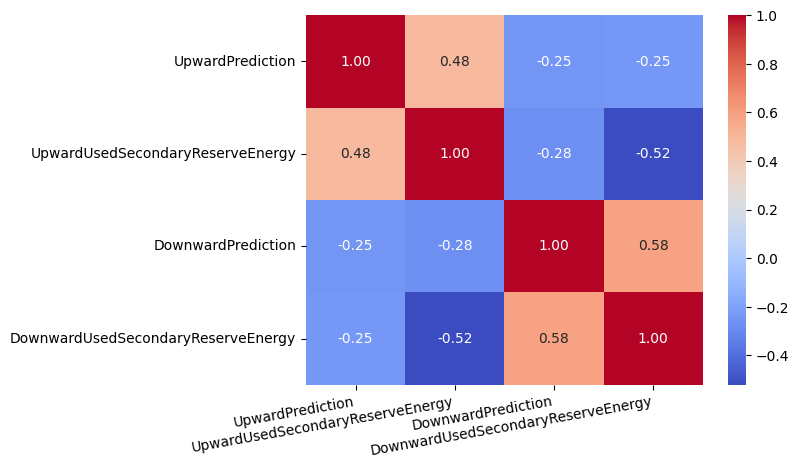

In [114]:
data = dataset_plot[columns_X].rename(
    {
        "UpwardPrediction": "Modelo a subir",
        "UpwardUsedSecondaryReserveEnergy": "Energia usada a subir",
        "DownwardPrediction": "Modelo a descer",
        "DownwardUsedSecondaryReserveEnergy": "Energia usada a descer",
    }
)

# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
plt.savefig(
    os.path.join(folder_figures, "heatmap_correlation_pred.png"),
    bbox_inches="tight",
)  # Specify the filename and path as needed
# Display the plot
plt.show()